In [5]:
import sys
import argparse
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
import matplotlib.image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from hw5_utils import *




# The "encoder" model q(z|x)
class Encoder(nn.Module):
    def __init__(self, latent_dimension, hidden_units, data_dimension):
        super(Encoder, self).__init__()
        # Input:
        #   latent_dimension: the latent dimension of the encoder
        #   hidden_units: the number of hidden units
        
        self.fc1 = nn.Linear(data_dimension, hidden_units)
        self.fc2_mu = nn.Linear(hidden_units, latent_dimension)
        self.fc2_sigma = nn.Linear(hidden_units, latent_dimension)

    def forward(self, x):
        # Input: x input image [batch_size x data_dimension]
        # Output: parameters of a diagonal gaussian 
        #   mean : [batch_size x latent_dimension]
        #   variance : [batch_size x latent_dimension]

        hidden = torch.tanh(self.fc1(x))
        mu = self.fc2_mu(hidden)
        log_sigma_square = self.fc2_sigma(hidden)
        sigma_square = torch.exp(log_sigma_square)  
        return mu, sigma_square


# "decoder" Model p(x|z)
class Decoder(nn.Module):
    def __init__(self, latent_dimension, hidden_units, data_dimension):
        super(Decoder, self).__init__()
        # Input:
        #   latent_dimension: the latent dimension of the encoder
        #   hidden_units: the number of hidden units

        # TODO: deine the parameters of the decoder
        # fc1: a fully connected layer with 500 hidden units. 
        # fc2: a fully connected layer with 500 hidden units. 
        self.fc1 = nn.Linear(latent_dimension, 500) 
        self.fc2 = nn.Linear(500, data_dimension)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    def forward(self, z):
        # input
        #   z: latent codes sampled from the encoder [batch_size x latent_dimension]
        # output 
        #   p: a tensor of the same size as the image indicating the probability of every pixel being 1 [batch_size x data_dimension]

        # TODO: implement the decoder here. The decoder is a multi-layer perceptron with two hidden layers. 
        # The first layer is followed by a tanh non-linearity and the second layer by a sigmoid.
        hidden = self.tanh(self.fc1(z))
        p = self.sigmoid(self.fc2(hidden))
        return p


# VAE model
class VAE(nn.Module):
    def __init__(self, args):
        super(VAE, self).__init__()
        self.latent_dimension = args.latent_dimension
        self.hidden_units =  args.hidden_units
        self.data_dimension = args.data_dimension
        self.resume_training = args.resume_training
        self.batch_size = args.batch_size
        self.num_epoches = args.num_epoches
        self.e_path = args.e_path
        self.d_path = args.d_path

        # load and pre-process the data
        N_data, self.train_images, self.train_labels, test_images, test_labels = load_mnist()

        # Instantiate the encoder and decoder models 
        self.encoder = Encoder(self.latent_dimension, self.hidden_units, self.data_dimension)
        self.decoder = Decoder(self.latent_dimension, self.hidden_units, self.data_dimension)

        # Load the trained model parameters
        if self.resume_training:
            self.encoder.load_state_dict(torch.load(self.e_path))
            self.decoder.load_state_dict(torch.load(self.d_path))

    # Sample from Diagonal Gaussian z~N(μ,σ^2 I) 
    @staticmethod
    def sample_diagonal_gaussian(mu, sigma_square):
        # Inputs:
        #   mu: mean of the gaussian [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian [batch_size x latent_dimension]
        # Output:
        #   sample: from a diagonal gaussian with mean mu and variance sigma_square [batch_size x latent_dimension]

        # TODO: Implement the reparameterization trick and return the sample z [batch_size x latent_dimension]
        sample = mu + torch.sqrt(sigma_square) * torch.randn(sigma_square.shape)
        return sample

    # Sampler from Bernoulli
    @staticmethod
    def sample_Bernoulli(p):
        # Input: 
        #   p: the probability of pixels labeled 1 [batch_size x data_dimension]
        # Output:
        #   x: pixels'labels [batch_size x data_dimension]

        # TODO: Implement a sampler from a Bernoulli distribution
        # x = torch.rand(p.shape[1])
        # x = (x>p).float()   
        x = torch.rand(p.shape)
        x = (x<p).float()        
        return x


    # Compute Log-pdf of z under Diagonal Gaussian N(z|μ,σ^2 I)
    @staticmethod
    def logpdf_diagonal_gaussian(z, mu, sigma_square):
        # Input:
        #   z: sample [batch_size x latent_dimension]
        #   mu: mean of the gaussian distribution [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian distribution [batch_size x latent_dimension]
        # Output:
        #    logprob: log-probability of a diagomnal gaussian [batch_size]
        
        # TODO: implement the logpdf of a gaussian with mean mu and variance sigma_square*I
#         log_sigma = torch.sum(torch.log(sigma_square), 1)
#         z_mu = z - mu
#         sigma_inverse = 1/sigma_square
#         k = z.shape[1]
        
#         logprob = -0.5 * (log_sigma + (z_mu.T @ sigma_inverse @ z_mu) - k/2 * np.log(np.pi *2))
#         # logprob = -0.5 * ((z - mu)/sigma_square)**2 - np.log(torch.sqrt(np.pi * 2) * torch.sqrt(sigma_square))
#         return logprob
          log_det_sigma = torch.sum(torch.log(sigma_square),-1) # batch_size
          #since the variance is diagonal, determinant is the product of elements on the diagonal
          z_mu_diff = z-mu # batch_size x dimension
          sigma_inverse = 1/sigma_square # batch_size x dimension
          k = z.shape[-1]
          s = z_mu_diff.shape[-1]
          logprob = -0.5*(log_det_sigma + torch.bmm(z_mu_diff.view(-1,1,s), (sigma_inverse * z_mu_diff).view(-1,s,1)).view(-1) + k * np.log(np.pi*2))
          return logprob

        # logprob = -0.5 * (log_sigma + torch.dot(z_mu, sigma_inverse * z_mu) - k * np.log(np.pi *2))
    # Compute log-pdf of x under Bernoulli 
    @staticmethod
    def logpdf_bernoulli(x, p):
        # Input:
        #   x: data samples [batch_size x data_dimension]
        #   p: the probability of the x being labeled 1 (p is the output of the decoder) [batch_size x data_dimension]
        # Output:
        #   logprob: log-probability of a diagonal gaussian [batch_size]

        # TODO: implement the log likelihood of a bernoulli distribution p(x)
        logprob = torch.sum(x*torch.log(p) + (1-x)*torch.log(1-p),-1)
        return logprob
    
    # Sample z ~ q(z|x)
    def sample_z(self, mu, sigma_square):
        # input:
        #   mu: mean of the gaussian [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian [batch_size x latent_dimension]
        # Output:
        #   zs: samples from q(z|x) [batch_size x latent_dimension] 
        zs = VAE.sample_diagonal_gaussian(mu, sigma_square)
        return zs 


    # Variational Objective
    def elbo_loss(self, sampled_z, mu, sigma_square, x, p):
        # Inputs
        #   sampled_z: samples z from the encoder [batch_size x latent_dimension]
        #   mu:
        #   sigma_square: parameters of q(z|x) [batch_size x 1]
        #   x: data samples [batch_size x data_dimension]
        #   p: the probability of a pixel being labeled 1 [batch_size x data_dimension]
        # Output
        #   elbo: the ELBO loss (scalar)

        # log_q(z|x) logprobability of z under approximate posterior N(μ,σ)
        log_q = self.logpdf_diagonal_gaussian(sampled_z, mu, sigma_square)
        
        # log_p_z(z) log probability of z under prior
        z_mu = torch.FloatTensor([0]*self.latent_dimension)
        z_sigma = torch.FloatTensor([1]*self.latent_dimension)
        log_p_z = self.logpdf_diagonal_gaussian(sampled_z, z_mu, z_sigma)

        # log_p(x|z) - conditional probability of data given latents.
        log_p = self.logpdf_bernoulli(x, p)
        
        # TODO: implement the ELBO loss using log_q, log_p_z and log_p
        elbo = torch.mean(log_p + log_p_z - log_q)
        return elbo


    def train(self):
        
        # Set-up ADAM optimizer
        params = list(self.encoder.parameters()) + list(self.decoder.parameters())
        adam_optimizer = optim.Adam(params)

        # Train for ~200 epochs 
        num_batches = int(np.ceil(len(self.train_images) / self.batch_size))
        num_iters = self.num_epoches * num_batches
        
        for i in range(num_iters):
            x_minibatch = self.train_images[batch_indices(i, num_batches, self.batch_size),:]
            adam_optimizer.zero_grad()

            mu, sigma_square = self.encoder(x_minibatch)
            zs = self.sample_z(mu, sigma_square)
            p = self.decoder(zs)
            elbo = self.elbo_loss(zs, mu, sigma_square, x_minibatch, p)
            total_loss = -elbo
            total_loss.backward()
            adam_optimizer.step()

            if i%100 == 0:
                print("Epoch: " + str(i//num_batches) + ", Iter: " + str(i) + ", ELBO:" + str(elbo.item()))

        # Save Optimized Model Parameters
        torch.save(self.encoder.state_dict(), self.e_path)
        torch.save(self.decoder.state_dict(), self.d_path)


    # Generate digits using the VAE
    def visualize_data_space(self):
        # TODO: Sample 10 z from prior 
        mu_z = torch.tensor([0]*self.latent_dimension).expand(10,-1).float()
        sigma_z = torch.tensor([1]*self.latent_dimension).expand(10,-1).float()
        sample_z = VAE.sample_diagonal_gaussian(mu_z, sigma_z)
        
        # TODO: For each z, plot p(x|z)
        plot = []
        # decoder = Decoder(self.latent_dimension, self.hidden_units, self.data_dimension)
        p_x_z = self.decoder(sample_z) #dimemsion: 10 * data_dimension  #this works because self.decoder = Decoder(three arguments) 
        # and when I do self.decoder(input), it automaticall calls forward
        for i in range(10):
            plot.append(array_to_image(p_x_z[i,:].detach().numpy())) #we don't include this part in GD 
        
        # TODO: Sample x from p(x|z) 
        sample_x = self.sample_Bernoulli(p_x_z)
        xs = []
        for i in range(10):
            xs.append(array_to_image(sample_x[i,:].detach().numpy()))


        # TODO: Concatenate plots into a figure (use the function concat_images)
        concated_image = concat_images(plot+xs, 10, 2)
        fig = plt.figure(figsize = (15,15))
        plt.axis('off')
        plt.imshow(concated_image)
        # TODO: Save the generated figure and include it in your report
        
        
    # Produce a scatter plot in the latent space, where each point in the plot will be the mean vector 
    # for the distribution $q(z|x)$ given by the encoder. Further, we will colour each point in the plot 
    # by the class label for the input data. Each point in the plot is colored by the class label for 
    # the input data.
    # The latent space should have learned to distinguish between elements from different classes, even though 
    # we never provided class labels to the model!
    def visualize_latent_space(self):
        
        # TODO: Encode the training data self.train_images
        mu, sigma_square = self.encoder(self.train_images)

        # TODO: Take the mean vector of each encoding
        mean = mu.detach().numpy()

        # TODO: Plot these mean vectors in the latent space with a scatter
        # Colour each point depending on the class label 
        colours = ["Red", "Yellow", "Olive", "Lime", "Green", 
                   "Aqua","Blue","Navy", "Fuchsia", "Purple"]
        fig = plt.figure(figsize = (10,10))
        for i in range(10): 
            sample_index = np.nonzero(self.train_labels.numpy()[:,i])[0]
            cur_digit_means = mean[sample_index]
            plt.scatter(cur_digit_means[:,0], cur_digit_means[:,1],c=colours[i])
        plt.show()
        

        # TODO: Save the generated figure and include it in your report
        


    # Function which gives linear interpolation z_α between za and zb
    @staticmethod
    def interpolate_mu(mua, mub, alpha = 0.5):
        return alpha*mua + (1-alpha)*mub


    # A common technique to assess latent representations is to interpolate between two points.
    # Here we will encode 3 pairs of data points with different classes.
    # Then we will linearly interpolate between the mean vectors of their encodings. 
    # We will plot the generative distributions along the linear interpolation.
    def visualize_inter_class_interpolation(self):
        
        # TODO: Sample 3 pairs of data with different classes
        pairs = []
        while len(pairs) < 3:
            i1 = int(np.random.rand() * 10000)
            i2 = int(np.random.rand() * 10000)
            if not self.train_labels[i1].equal(self.train_labels[i2]):
                pairs.append([self.train_images[i1],self.train_images[i2]])        

        # Encode the data in each pair, and take the mean vectors
        pairs_mus = []
        for p in pairs:
            mu1, sigma_square1 = self.encoder(p[0])
            mu2, sigma_square2 = self.encoder(p[1])
            pairs_mus.append([mu1,mu2])

        # Linearly interpolate between these mean vectors
        z_alphas = []
        for alpha in np.arange(0,1.1,0.1):
            for p in pairs_mus:
                z_alphas.append(VAE.interpolate_mu(p[0],p[1],alpha))

        # Along the interpolation, plot the distributions p(x|z_α)
        plots = []
        for z in z_alphas:
            y = self.decoder(z)
            plots.append(array_to_image(y.detach().numpy()))

        # Concatenate these plots into one figure
        final_plot = concat_images(plots, 3,11)
        fig = plt.figure(figsize = (10,10))
        plt.axis('off')
        plt.imshow(final_plot)
      

def parse_args():
    parser = argparse.ArgumentParser(description=globals()['__doc__'])

    parser.add_argument('--e_path', type=str, default="./e_params.pkl", help='Path to the encoder parameters.')
    parser.add_argument('--d_path', type=str, default="./d_params.pkl", help='Path to the decoder parameters.')
    parser.add_argument('--hidden_units', type=int, default=500, help='Number of hidden units of the encoder and decoder models.')
    parser.add_argument('--latent_dimension', type=int, default='2', help='Dimensionality of the latent space.')
    parser.add_argument('--data_dimension', type=int, default='784', help='Dimensionality of the data space.')
    parser.add_argument('--resume_training', action='store_true', help='Whether to resume training')
    parser.add_argument('--seed', type=int, default=1234, help='Random seed')
    parser.add_argument('--num_epoches', type=int, default=200, help='Number of epochs for training.')
    parser.add_argument('--batch_size', type=int, default=100, help='Batch size.')

#     args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    return args


def main():
    
    # read the function arguments
    args = parse_args()

    # set the random seed 
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)
    
    # train the model 
    vae = VAE(args)
    vae.train()

    # visualize the latent space
    vae.visualize_data_space()
    vae.visualize_latent_space()
    vae.visualize_inter_class_interpolation()

main()

Epoch: 0, Iter: 0, ELBO:-548.4129638671875
Epoch: 1, Iter: 100, ELBO:-182.0055694580078
Epoch: 2, Iter: 200, ELBO:-178.53799438476562
Epoch: 3, Iter: 300, ELBO:-175.31761169433594


KeyboardInterrupt: 

In [ ]:
import sys
import argparse
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
import matplotlib.image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from hw5_utils import *




# The "encoder" model q(z|x)
class Encoder(nn.Module):
    def __init__(self, latent_dimension, hidden_units, data_dimension):
        super(Encoder, self).__init__()
        # Input:
        #   latent_dimension: the latent dimension of the encoder
        #   hidden_units: the number of hidden units
        
        self.fc1 = nn.Linear(data_dimension, hidden_units)
        self.fc2_mu = nn.Linear(hidden_units, latent_dimension)
        self.fc2_sigma = nn.Linear(hidden_units, latent_dimension)

    def forward(self, x):
        # Input: x input image [batch_size x data_dimension]
        # Output: parameters of a diagonal gaussian 
        #   mean : [batch_size x latent_dimension]
        #   variance : [batch_size x latent_dimension]

        hidden = torch.tanh(self.fc1(x))
        mu = self.fc2_mu(hidden)
        log_sigma_square = self.fc2_sigma(hidden)
        sigma_square = torch.exp(log_sigma_square)  
        return mu, sigma_square


# "decoder" Model p(x|z)
class Decoder(nn.Module):
    def __init__(self, latent_dimension, hidden_units, data_dimension):
        super(Decoder, self).__init__()
        # Input:
        #   latent_dimension: the latent dimension of the encoder
        #   hidden_units: the number of hidden units

        # TODO: deine the parameters of the decoder
        # fc1: a fully connected layer with 500 hidden units. 
        # fc2: a fully connected layer with 500 hidden units. 
        self.fc1 = nn.Linear(latent_dimension, 500) 
        self.fc2 = nn.Linear(500, data_dimension)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    def forward(self, z):
        # input
        #   z: latent codes sampled from the encoder [batch_size x latent_dimension]
        # output 
        #   p: a tensor of the same size as the image indicating the probability of every pixel being 1 [batch_size x data_dimension]

        # TODO: implement the decoder here. The decoder is a multi-layer perceptron with two hidden layers. 
        # The first layer is followed by a tanh non-linearity and the second layer by a sigmoid.
        hidden = self.tanh(self.fc1(z))
        p = self.sigmoid(self.fc2(hidden))
        return p


# VAE model
class VAE(nn.Module):
    def __init__(self, args):
        super(VAE, self).__init__()
        self.latent_dimension = args.latent_dimension
        self.hidden_units =  args.hidden_units
        self.data_dimension = args.data_dimension
        self.resume_training = args.resume_training
        self.batch_size = args.batch_size
        self.num_epoches = args.num_epoches
        self.e_path = args.e_path
        self.d_path = args.d_path

        # load and pre-process the data
        N_data, self.train_images, self.train_labels, test_images, test_labels = load_mnist()

        # Instantiate the encoder and decoder models 
        self.encoder = Encoder(self.latent_dimension, self.hidden_units, self.data_dimension)
        self.decoder = Decoder(self.latent_dimension, self.hidden_units, self.data_dimension)

        # Load the trained model parameters
        if self.resume_training:
            self.encoder.load_state_dict(torch.load(self.e_path))
            self.decoder.load_state_dict(torch.load(self.d_path))

    # Sample from Diagonal Gaussian z~N(μ,σ^2 I) 
    @staticmethod
    def sample_diagonal_gaussian(mu, sigma_square):
        # Inputs:
        #   mu: mean of the gaussian [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian [batch_size x latent_dimension]
        # Output:
        #   sample: from a diagonal gaussian with mean mu and variance sigma_square [batch_size x latent_dimension]

        # TODO: Implement the reparameterization trick and return the sample z [batch_size x latent_dimension]
        sample = mu + torch.sqrt(sigma_square) * torch.randn(sigma_square.shape)
        return sample

    # Sampler from Bernoulli
    @staticmethod
    def sample_Bernoulli(p):
        # Input: 
        #   p: the probability of pixels labeled 1 [batch_size x data_dimension]
        # Output:
        #   x: pixels'labels [batch_size x data_dimension]

        # TODO: Implement a sampler from a Bernoulli distribution
        # x = torch.rand(p.shape[1])
        # x = (x>p).float()   
        x = torch.rand(p.shape)
        x = (x<p).float()        
        return x


    # Compute Log-pdf of z under Diagonal Gaussian N(z|μ,σ^2 I)
    @staticmethod
    def logpdf_diagonal_gaussian(z, mu, sigma_square):
        # Input:
        #   z: sample [batch_size x latent_dimension]
        #   mu: mean of the gaussian distribution [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian distribution [batch_size x latent_dimension]
        # Output:
        #    logprob: log-probability of a diagomnal gaussian [batch_size]
        
        # TODO: implement the logpdf of a gaussian with mean mu and variance sigma_square*I
#         log_sigma = torch.sum(torch.log(sigma_square), 1)
#         z_mu = z - mu
#         sigma_inverse = 1/sigma_square
#         k = z.shape[1]
        
#         logprob = -0.5 * (log_sigma + (z_mu.T @ sigma_inverse @ z_mu) - k/2 * np.log(np.pi *2))
#         # logprob = -0.5 * ((z - mu)/sigma_square)**2 - np.log(torch.sqrt(np.pi * 2) * torch.sqrt(sigma_square))
#         return logprob
          log_det_sigma = torch.sum(torch.log(sigma_square),-1) # batch_size
          #since the variance is diagonal, determinant is the product of elements on the diagonal
          z_mu_diff = z-mu # batch_size x dimension
          sigma_inverse = 1/sigma_square # batch_size x dimension
          k = z.shape[-1]
          s = z_mu_diff.shape[-1]
          logprob = -0.5*(log_det_sigma + torch.bmm(z_mu_diff.view(-1,1,s), (sigma_inverse * z_mu_diff).view(-1,s,1)).view(-1) + k * np.log(np.pi*2))
          return logprob

        # logprob = -0.5 * (log_sigma + torch.dot(z_mu, sigma_inverse * z_mu) - k * np.log(np.pi *2))
    # Compute log-pdf of x under Bernoulli 
    @staticmethod
    def logpdf_bernoulli(x, p):
        # Input:
        #   x: data samples [batch_size x data_dimension]
        #   p: the probability of the x being labeled 1 (p is the output of the decoder) [batch_size x data_dimension]
        # Output:
        #   logprob: log-probability of a diagonal gaussian [batch_size]

        # TODO: implement the log likelihood of a bernoulli distribution p(x)
        logprob = torch.sum(x*torch.log(p) + (1-x)*torch.log(1-p),-1)
        return logprob
    
    # Sample z ~ q(z|x)
    def sample_z(self, mu, sigma_square):
        # input:
        #   mu: mean of the gaussian [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian [batch_size x latent_dimension]
        # Output:
        #   zs: samples from q(z|x) [batch_size x latent_dimension] 
        zs = VAE.sample_diagonal_gaussian(mu, sigma_square)
        return zs 


    # Variational Objective
    def elbo_loss(self, sampled_z, mu, sigma_square, x, p):
        # Inputs
        #   sampled_z: samples z from the encoder [batch_size x latent_dimension]
        #   mu:
        #   sigma_square: parameters of q(z|x) [batch_size x 1]
        #   x: data samples [batch_size x data_dimension]
        #   p: the probability of a pixel being labeled 1 [batch_size x data_dimension]
        # Output
        #   elbo: the ELBO loss (scalar)

        # log_q(z|x) logprobability of z under approximate posterior N(μ,σ)
        log_q = self.logpdf_diagonal_gaussian(sampled_z, mu, sigma_square)
        
        # log_p_z(z) log probability of z under prior
        z_mu = torch.FloatTensor([0]*self.latent_dimension)
        z_sigma = torch.FloatTensor([1]*self.latent_dimension)
        log_p_z = self.logpdf_diagonal_gaussian(sampled_z, z_mu, z_sigma)

        # log_p(x|z) - conditional probability of data given latents.
        log_p = self.logpdf_bernoulli(x, p)
        
        # TODO: implement the ELBO loss using log_q, log_p_z and log_p
        elbo = torch.mean(log_p + log_p_z - log_q)
        return elbo


    def train(self):
        
        # Set-up ADAM optimizer
        params = list(self.encoder.parameters()) + list(self.decoder.parameters())
        adam_optimizer = optim.Adam(params)

        # Train for ~200 epochs 
        num_batches = int(np.ceil(len(self.train_images) / self.batch_size))
        num_iters = self.num_epoches * num_batches
        
        for i in range(num_iters):
            x_minibatch = self.train_images[batch_indices(i, num_batches, self.batch_size),:]
            adam_optimizer.zero_grad()

            mu, sigma_square = self.encoder(x_minibatch)
            zs = self.sample_z(mu, sigma_square)
            p = self.decoder(zs)
            elbo = self.elbo_loss(zs, mu, sigma_square, x_minibatch, p)
            total_loss = -elbo
            total_loss.backward()
            adam_optimizer.step()

            if i%100 == 0:
                print("Epoch: " + str(i//num_batches) + ", Iter: " + str(i) + ", ELBO:" + str(elbo.item()))

        # Save Optimized Model Parameters
        torch.save(self.encoder.state_dict(), self.e_path)
        torch.save(self.decoder.state_dict(), self.d_path)


    # Generate digits using the VAE
    def visualize_data_space(self):
        # TODO: Sample 10 z from prior 
        mu_z = torch.tensor([0]*self.latent_dimension).expand(10,-1).float()
        sigma_z = torch.tensor([1]*self.latent_dimension).expand(10,-1).float()
        sample_z = VAE.sample_diagonal_gaussian(mu_z, sigma_z)
        
        # TODO: For each z, plot p(x|z)
        plot = []
        # decoder = Decoder(self.latent_dimension, self.hidden_units, self.data_dimension)
        p_x_z = self.decoder(sample_z) #dimemsion: 10 * data_dimension  #this works because self.decoder = Decoder(three arguments) 
        # and when I do self.decoder(input), it automaticall calls forward
        for i in range(10):
            plot.append(array_to_image(p_x_z[i,:].detach().numpy())) #we don't include this part in GD 
        
        # TODO: Sample x from p(x|z) 
        sample_x = self.sample_Bernoulli(p_x_z)
        xs = []
        for i in range(10):
            xs.append(array_to_image(sample_x[i,:].detach().numpy()))


        # TODO: Concatenate plots into a figure (use the function concat_images)
        concated_image = concat_images(plot+xs, 10, 2)
        fig = plt.figure(figsize = (15,15))
        plt.axis('off')
        plt.imshow(concated_image)
        # TODO: Save the generated figure and include it in your report
        
        
    # Produce a scatter plot in the latent space, where each point in the plot will be the mean vector 
    # for the distribution $q(z|x)$ given by the encoder. Further, we will colour each point in the plot 
    # by the class label for the input data. Each point in the plot is colored by the class label for 
    # the input data.
    # The latent space should have learned to distinguish between elements from different classes, even though 
    # we never provided class labels to the model!
    def visualize_latent_space(self):
        
        # TODO: Encode the training data self.train_images
        mu, sigma_square = self.encoder(self.train_images)

        # TODO: Take the mean vector of each encoding
        mean = mu.detach().numpy()

        # TODO: Plot these mean vectors in the latent space with a scatter
        # Colour each point depending on the class label 
        colours = ["Red", "Yellow", "Olive", "Lime", "Green", 
                   "Aqua","Blue","Navy", "Fuchsia", "Purple"]
        fig = plt.figure(figsize = (10,10))
        for i in range(10): 
            sample_index = np.nonzero(self.train_labels.numpy()[:,i])[0]
            cur_digit_means = mean[sample_index]
            plt.scatter(cur_digit_means[:,0], cur_digit_means[:,1],c=colours[i])
        plt.show()
        

        # TODO: Save the generated figure and include it in your report
        


    # Function which gives linear interpolation z_α between za and zb
    @staticmethod
    def interpolate_mu(mua, mub, alpha = 0.5):
        return alpha*mua + (1-alpha)*mub


    # A common technique to assess latent representations is to interpolate between two points.
    # Here we will encode 3 pairs of data points with different classes.
    # Then we will linearly interpolate between the mean vectors of their encodings. 
    # We will plot the generative distributions along the linear interpolation.
    def visualize_inter_class_interpolation(self):
        
        # TODO: Sample 3 pairs of data with different classes
        pairs = []
        while len(pairs) < 3:
            i1 = int(np.random.rand() * 10000)
            i2 = int(np.random.rand() * 10000)
            if not self.train_labels[i1].equal(self.train_labels[i2]):
                pairs.append([self.train_images[i1],self.train_images[i2]])        

        # Encode the data in each pair, and take the mean vectors
        pairs_mus = []
        for p in pairs:
            mu1, sigma_square1 = self.encoder(p[0])
            mu2, sigma_square2 = self.encoder(p[1])
            pairs_mus.append([mu1,mu2])

        # Linearly interpolate between these mean vectors
        z_alphas = []
        for alpha in np.arange(0,1.1,0.1):
            for p in pairs_mus:
                z_alphas.append(VAE.interpolate_mu(p[0],p[1],alpha))

        # Along the interpolation, plot the distributions p(x|z_α)
        plots = []
        for z in z_alphas:
            y = self.decoder(z)
            plots.append(array_to_image(y.detach().numpy()))

        # Concatenate these plots into one figure
        final_plot = concat_images(plots, 3,11)
        fig = plt.figure(figsize = (10,10))
        plt.axis('off')
        plt.imshow(final_plot)
      

def parse_args():
    parser = argparse.ArgumentParser(description=globals()['__doc__'])

    parser.add_argument('--e_path', type=str, default="./e_params.pkl", help='Path to the encoder parameters.')
    parser.add_argument('--d_path', type=str, default="./d_params.pkl", help='Path to the decoder parameters.')
    parser.add_argument('--hidden_units', type=int, default=500, help='Number of hidden units of the encoder and decoder models.')
    parser.add_argument('--latent_dimension', type=int, default='2', help='Dimensionality of the latent space.')
    parser.add_argument('--data_dimension', type=int, default='784', help='Dimensionality of the data space.')
    parser.add_argument('--resume_training', action='store_true', help='Whether to resume training')
    parser.add_argument('--seed', type=int, default=1234, help='Random seed')
    parser.add_argument('--num_epoches', type=int, default=200, help='Number of epochs for training.')
    parser.add_argument('--batch_size', type=int, default=100, help='Batch size.')

#     args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    return args


def main():
    
    # read the function arguments
    args = parse_args()

    # set the random seed 
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)
    
    # train the model 
    vae = VAE(args)
    vae.train()

    # visualize the latent space
    vae.visualize_data_space()
    vae.visualize_latent_space()
    vae.visualize_inter_class_interpolation()



Processing dataset ...




  0%|                                                                                          | 0/100 [00:00<?, ?it/s]


  0%|                                                                                          | 0/234 [00:00<?, ?it/s]

... done. Total 60000 data entries.





  0%|▎                                                                                 | 1/234 [00:00<01:34,  2.46it/s]


  1%|▋                                                                                 | 2/234 [00:00<01:17,  2.98it/s]


  1%|█                                                                                 | 3/234 [00:00<01:06,  3.48it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:58,  3.93it/s]


  2%|█▊                                                                                | 5/234 [00:01<00:52,  4.35it/s]


  3%|██                                                                                | 6/234 [00:01<00:48,  4.68it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:45,  4.95it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:43,  5.14it/s]


  4%|███▏            

 27%|█████████████████████▊                                                           | 63/234 [00:11<00:29,  5.80it/s]


 27%|██████████████████████▏                                                          | 64/234 [00:11<00:29,  5.76it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:11<00:29,  5.79it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:11<00:28,  5.80it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:11<00:28,  5.78it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:28,  5.78it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:28,  5.79it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:28,  5.78it/s]


 30%|███████████████████

 53%|██████████████████████████████████████████▋                                     | 125/234 [00:21<00:18,  5.80it/s]


 54%|███████████████████████████████████████████                                     | 126/234 [00:22<00:18,  5.80it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:22<00:18,  5.81it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:22<00:18,  5.78it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:22<00:18,  5.78it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:22<00:17,  5.82it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:22<00:17,  5.76it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:23<00:17,  5.77it/s]


 57%|███████████████████

 80%|███████████████████████████████████████████████████████████████▉                | 187/234 [00:32<00:08,  5.60it/s]


 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:33<00:08,  5.66it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:33<00:07,  5.66it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:33<00:07,  5.70it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:33<00:07,  5.68it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:33<00:07,  5.74it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:33<00:07,  5.67it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:34<00:06,  5.74it/s]


 83%|███████████████████

E: 0; DLoss: 0.7851042747497559; GLoss: 0.5191643238067627





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.90it/s]


  1%|█                                                                                 | 3/234 [00:00<00:35,  6.46it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:36,  6.27it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:37,  6.08it/s]


  3%|██                                                                                | 6/234 [00:01<00:38,  5.98it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:38,  5.82it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:38,  5.82it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:39,  5.65it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:29,  5.70it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:11<00:29,  5.71it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:11<00:29,  5.69it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:11<00:29,  5.72it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:11<00:29,  5.70it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:28,  5.69it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:28,  5.70it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:12<00:28,  5.72it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:22<00:19,  5.68it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:22<00:18,  5.70it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:22<00:18,  5.70it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:22<00:18,  5.71it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:22<00:18,  5.69it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:22<00:18,  5.71it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:23<00:17,  5.71it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:23<00:17,  5.73it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:32<00:08,  5.70it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:33<00:07,  5.65it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:33<00:07,  5.66it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:33<00:07,  5.70it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:33<00:07,  5.66it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:33<00:07,  5.69it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:34<00:07,  5.67it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:34<00:06,  5.66it/s]


 84%|███████████████████

E: 1; DLoss: 0.6990545392036438; GLoss: 0.6404411792755127





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.84it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.37it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.12it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:38,  5.98it/s]


  3%|██                                                                                | 6/234 [00:01<00:38,  5.86it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:39,  5.75it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:39,  5.79it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:39,  5.72it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:29,  5.67it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:11<00:29,  5.66it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:11<00:29,  5.71it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:11<00:29,  5.70it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:11<00:29,  5.69it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:29,  5.69it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:28,  5.70it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:12<00:28,  5.71it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:22<00:19,  5.53it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:22<00:19,  5.59it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:22<00:19,  5.57it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:22<00:18,  5.64it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:22<00:18,  5.60it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:23<00:18,  5.56it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:23<00:18,  5.57it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:23<00:18,  5.60it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:33<00:08,  5.45it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:33<00:08,  5.50it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:33<00:08,  5.48it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:33<00:07,  5.47it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:34<00:07,  5.49it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:34<00:07,  5.53it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:34<00:07,  5.57it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:34<00:07,  5.53it/s]


 84%|███████████████████

E: 2; DLoss: 0.7097727060317993; GLoss: 0.7077149748802185





  1%|▋                                                                                 | 2/234 [00:00<00:32,  7.10it/s]


  1%|█                                                                                 | 3/234 [00:00<00:34,  6.63it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:36,  6.29it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:37,  6.07it/s]


  3%|██                                                                                | 6/234 [00:01<00:38,  5.95it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:39,  5.81it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:38,  5.80it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:39,  5.74it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:30,  5.48it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:11<00:30,  5.50it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:11<00:30,  5.44it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:30,  5.49it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.48it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.49it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:29,  5.47it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:12<00:29,  5.50it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:22<00:19,  5.49it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:22<00:19,  5.49it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.50it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:23<00:18,  5.55it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:23<00:18,  5.56it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:23<00:18,  5.54it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:23<00:18,  5.52it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:23<00:18,  5.55it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:34<00:08,  5.45it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:34<00:08,  5.51it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:34<00:08,  5.48it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:34<00:07,  5.48it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:34<00:07,  5.48it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:34<00:07,  5.47it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:35<00:07,  5.48it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:35<00:07,  5.45it/s]


 84%|███████████████████

E: 3; DLoss: 0.7064603567123413; GLoss: 0.7105440497398376





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.83it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.38it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.08it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.83it/s]


  3%|██                                                                                | 6/234 [00:01<00:39,  5.76it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.66it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.60it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:40,  5.54it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.42it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:11<00:30,  5.46it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.41it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:30,  5.49it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.48it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.48it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:30,  5.45it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:12<00:29,  5.47it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:19,  5.41it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.41it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.42it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:23<00:19,  5.46it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:23<00:18,  5.52it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:23<00:18,  5.53it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.50it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.49it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:34<00:08,  5.44it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:34<00:08,  5.43it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:34<00:08,  5.44it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:34<00:07,  5.47it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.43it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:35<00:07,  5.50it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:35<00:07,  5.52it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:35<00:07,  5.49it/s]


 84%|███████████████████

E: 4; DLoss: 0.692920446395874; GLoss: 0.726844310760498





  1%|▋                                                                                 | 2/234 [00:00<00:38,  6.08it/s]


  1%|█                                                                                 | 3/234 [00:00<00:38,  5.98it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:39,  5.82it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:40,  5.70it/s]


  3%|██                                                                                | 6/234 [00:01<00:39,  5.70it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.63it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:48,  4.66it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:45,  4.92it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:39,  4.26it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:36,  4.64it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:34,  4.89it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:32,  5.07it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:13<00:32,  5.18it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:31,  5.26it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:39,  4.17it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:35,  4.62it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:19,  5.49it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:19,  5.45it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:19,  5.40it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.39it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.45it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:18,  5.49it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:18,  5.50it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:18,  5.45it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.42it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.40it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.38it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:07,  5.44it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.45it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.48it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.46it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.44it/s]


 84%|███████████████████

E: 5; DLoss: 0.7014045715332031; GLoss: 0.7093281745910645





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.93it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.39it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.15it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:38,  5.96it/s]


  3%|██                                                                                | 6/234 [00:01<00:39,  5.79it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:39,  5.71it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.64it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:40,  5.61it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:31,  5.45it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.44it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.39it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:30,  5.48it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.38it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:30,  5.47it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:29,  5.47it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:29,  5.49it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:19,  5.41it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.47it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.46it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.35it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.42it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:18,  5.46it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.42it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.49it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:34<00:08,  5.51it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.49it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.49it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:07,  5.48it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.47it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:35<00:07,  5.47it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:35<00:07,  5.46it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.50it/s]


 84%|███████████████████

E: 6; DLoss: 0.6949708461761475; GLoss: 0.7058118581771851





  1%|▋                                                                                 | 2/234 [00:00<00:32,  7.11it/s]


  1%|█                                                                                 | 3/234 [00:00<00:35,  6.54it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.17it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:38,  5.94it/s]


  3%|██                                                                                | 6/234 [00:01<00:39,  5.83it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:39,  5.71it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.65it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:40,  5.57it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:30,  5.49it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:11<00:30,  5.48it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:11<00:30,  5.49it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:30,  5.50it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.48it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.49it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:30,  5.45it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:12<00:29,  5.48it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:19,  5.44it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.43it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.43it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:23<00:19,  5.46it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.45it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:18,  5.46it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.46it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.43it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:12,  3.71it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:11,  4.06it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:09,  4.40it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:09,  4.69it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:08,  4.83it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:08,  5.03it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.14it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.17it/s]


 84%|███████████████████

E: 7; DLoss: 0.6912336349487305; GLoss: 0.6864778995513916





  0%|▎                                                                                 | 1/234 [00:00<00:31,  7.41it/s]


  1%|▋                                                                                 | 2/234 [00:00<00:34,  6.71it/s]


  1%|█                                                                                 | 3/234 [00:00<00:37,  6.16it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:39,  5.87it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.77it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.65it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.56it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.52it/s]


  4%|███▏            

 27%|█████████████████████▊                                                           | 63/234 [00:11<00:31,  5.35it/s]


 27%|██████████████████████▏                                                          | 64/234 [00:11<00:32,  5.30it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:11<00:31,  5.32it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.36it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.37it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.34it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.35it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:30,  5.38it/s]


 30%|███████████████████

 53%|██████████████████████████████████████████▋                                     | 125/234 [00:23<00:20,  5.33it/s]


 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.35it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.34it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.34it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:23<00:19,  5.38it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.37it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.36it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.38it/s]


 57%|███████████████████

 80%|███████████████████████████████████████████████████████████████▉                | 187/234 [00:34<00:08,  5.32it/s]


 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:34<00:08,  5.32it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.35it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.42it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:07,  5.41it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.42it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:35<00:07,  5.40it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.40it/s]


 83%|███████████████████

E: 8; DLoss: 0.6896896958351135; GLoss: 0.6892482042312622





  1%|▋                                                                                 | 2/234 [00:00<00:34,  6.64it/s]


  1%|█                                                                                 | 3/234 [00:00<00:37,  6.20it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.92it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.74it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.64it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.59it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.50it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.44it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.37it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.40it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.40it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.37it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.39it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.36it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:30,  5.39it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.36it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.38it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.38it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.39it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:23<00:19,  5.40it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.40it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:18,  5.42it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.41it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.35it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:34<00:08,  5.40it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.39it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.42it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:07,  5.41it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.39it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:35<00:07,  5.39it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:35<00:07,  5.38it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.41it/s]


 84%|███████████████████

E: 9; DLoss: 0.6930340528488159; GLoss: 0.6936066746711731





  1%|▋                                                                                 | 2/234 [00:00<00:40,  5.78it/s]


  1%|█                                                                                 | 3/234 [00:00<00:41,  5.62it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:41,  5.57it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:41,  5.56it/s]


  3%|██                                                                                | 6/234 [00:01<00:42,  5.31it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:43,  5.22it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:42,  5.27it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:42,  5.29it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.41it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.41it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.40it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.37it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.37it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.38it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.39it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.35it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.38it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.38it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:19,  5.38it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.39it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.39it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:18,  5.42it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.41it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.43it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.41it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.42it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.37it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.30it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.32it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.34it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.38it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.40it/s]


 84%|███████████████████

E: 10; DLoss: 0.6897695064544678; GLoss: 0.6913432478904724





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.93it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.36it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  6.04it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.84it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.66it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.59it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.52it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:40,  5.52it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.40it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:11<00:31,  5.42it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.42it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:30,  5.41it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.40it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.39it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:30,  5.35it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.37it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:25,  4.27it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:22,  4.68it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:22,  4.78it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:21,  4.88it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:22,  4.59it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:22,  4.68it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:21,  4.79it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:20,  4.84it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:36<00:08,  5.37it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:08,  5.36it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.27it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.31it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.37it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:37<00:07,  5.37it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:07,  5.38it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.37it/s]


 84%|███████████████████

E: 11; DLoss: 0.6788047552108765; GLoss: 0.6941747665405273





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.87it/s]


  1%|█                                                                                 | 3/234 [00:00<00:43,  5.32it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:41,  5.50it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:41,  5.54it/s]


  3%|██                                                                                | 6/234 [00:01<00:41,  5.54it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.47it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.44it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.41it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.41it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.40it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.42it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:30,  5.40it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.40it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.39it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.33it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.39it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.38it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.40it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:20,  5.23it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.34it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.34it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.37it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.38it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.33it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.33it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.34it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.22it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:08,  5.35it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.36it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.36it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.36it/s]


 84%|███████████████████

E: 12; DLoss: 0.6797292232513428; GLoss: 0.6987808346748352





  1%|▋                                                                                 | 2/234 [00:00<00:35,  6.54it/s]


  1%|█                                                                                 | 3/234 [00:00<00:37,  6.18it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.93it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.78it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.68it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.57it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.54it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:40,  5.50it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.34it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.30it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.34it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:32,  5.19it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.29it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:31,  5.32it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.25it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.35it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.40it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.42it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.41it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.39it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.42it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:18,  5.42it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.42it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.40it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:34<00:08,  5.38it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.35it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.35it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:08,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.38it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:35<00:07,  5.39it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.41it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.35it/s]


 84%|███████████████████

E: 13; DLoss: 0.6735554933547974; GLoss: 0.7154285311698914





  1%|▋                                                                                 | 2/234 [00:00<00:33,  7.01it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.41it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.08it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.85it/s]


  3%|██                                                                                | 6/234 [00:01<00:39,  5.72it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.64it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.55it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.41it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.42it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.44it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:30,  5.42it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:30,  5.41it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.41it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.42it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:30,  5.43it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.41it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:24,  4.47it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:22,  4.73it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:21,  4.90it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:20,  5.04it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:20,  5.14it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.21it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.11it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:20,  4.91it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.41it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.35it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.39it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.37it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.41it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.43it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.42it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.41it/s]


 84%|███████████████████

E: 14; DLoss: 0.6774226427078247; GLoss: 0.7016415596008301





  1%|▋                                                                                 | 2/234 [00:00<00:32,  7.12it/s]


  1%|█                                                                                 | 3/234 [00:00<00:35,  6.51it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.14it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:38,  5.89it/s]


  3%|██                                                                                | 6/234 [00:01<00:39,  5.73it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.62it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.57it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:40,  5.50it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.38it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.37it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.30it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.35it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.37it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.36it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.38it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.36it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:24,  4.43it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:23,  4.65it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:22,  4.79it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:21,  4.86it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:20,  5.11it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.19it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.28it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:20,  4.96it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.41it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.41it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.41it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:07,  5.42it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.42it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.41it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.41it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.39it/s]


 84%|███████████████████

E: 15; DLoss: 0.6453207731246948; GLoss: 0.7396662831306458





  1%|▋                                                                                 | 2/234 [00:00<00:32,  7.14it/s]


  1%|█                                                                                 | 3/234 [00:00<00:35,  6.51it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.11it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:38,  5.91it/s]


  3%|██                                                                                | 6/234 [00:01<00:39,  5.73it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.66it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.58it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:40,  5.53it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.40it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.40it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.40it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:30,  5.39it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.38it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.42it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.38it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.42it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:21,  5.06it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.18it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.24it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.29it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.34it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.35it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.36it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:18,  5.39it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.34it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:10,  4.41it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:09,  4.47it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  4.78it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:08,  4.94it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:08,  5.10it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.19it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.26it/s]


 84%|███████████████████

E: 16; DLoss: 0.6932896971702576; GLoss: 0.7077832221984863





  1%|▋                                                                                 | 2/234 [00:00<00:33,  7.02it/s]


  1%|█                                                                                 | 3/234 [00:00<00:35,  6.46it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.07it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.86it/s]


  3%|██                                                                                | 6/234 [00:01<00:39,  5.73it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.63it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.56it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:40,  5.50it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:31,  5.39it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.40it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:30,  5.44it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:30,  5.44it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.44it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.43it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.39it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.41it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:19,  5.41it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.43it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.42it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.42it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.40it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.24it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.32it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.35it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.43it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.43it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.41it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:07,  5.39it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.39it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:35<00:07,  5.40it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.35it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.43it/s]


 84%|███████████████████

E: 17; DLoss: 0.6399608850479126; GLoss: 0.7798318862915039





  1%|▋                                                                                 | 2/234 [00:00<00:34,  6.81it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.37it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  6.02it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.83it/s]


  3%|██                                                                                | 6/234 [00:01<00:39,  5.73it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.64it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.56it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.46it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.42it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:11<00:31,  5.41it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.41it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:30,  5.41it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.41it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.41it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:30,  5.40it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.43it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:19,  5.42it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.42it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.43it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:23<00:19,  5.43it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.42it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.42it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.40it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.42it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:34<00:08,  5.42it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:34<00:08,  5.43it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.40it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:07,  5.41it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.42it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:35<00:07,  5.43it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:35<00:07,  5.41it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.40it/s]


 84%|███████████████████

E: 18; DLoss: 0.6519883275032043; GLoss: 0.7476530075073242





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.90it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.41it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.06it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.84it/s]


  3%|██                                                                                | 6/234 [00:01<00:39,  5.71it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.63it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.55it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:40,  5.50it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.37it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.42it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:30,  5.43it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:30,  5.42it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.40it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.41it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:30,  5.42it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.41it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:19,  5.42it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.44it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.42it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:23<00:19,  5.40it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.42it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:18,  5.42it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.43it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.42it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:34<00:08,  5.42it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:34<00:08,  5.42it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.40it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:07,  5.42it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.42it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:35<00:07,  5.41it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:35<00:07,  5.43it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.43it/s]


 84%|███████████████████

E: 19; DLoss: 0.6894699335098267; GLoss: 0.742512583732605





  1%|▋                                                                                 | 2/234 [00:00<00:40,  5.76it/s]


  1%|█                                                                                 | 3/234 [00:00<00:40,  5.64it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:41,  5.55it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:41,  5.52it/s]


  3%|██                                                                                | 6/234 [00:01<00:41,  5.47it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.46it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.49it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:42,  5.31it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.43it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.42it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.40it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.28it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.31it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:31,  5.30it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:30,  5.37it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.39it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.36it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.39it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.41it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.41it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.41it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.41it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.42it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.41it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.40it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.41it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.43it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:07,  5.41it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.42it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:35<00:07,  5.43it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.43it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.42it/s]


 84%|███████████████████

E: 20; DLoss: 0.7064196467399597; GLoss: 0.7450746893882751





  1%|▋                                                                                 | 2/234 [00:00<00:32,  7.10it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.34it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  6.03it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.79it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.65it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.62it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.53it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:40,  5.51it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.43it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.42it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:30,  5.43it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:30,  5.41it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.42it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.41it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:30,  5.41it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.40it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:19,  5.40it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.40it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.43it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:23<00:19,  5.40it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.41it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.42it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.38it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:20,  5.03it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:34<00:08,  5.35it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.40it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.41it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:07,  5.38it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.38it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:35<00:07,  5.41it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.42it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.41it/s]


 84%|███████████████████

E: 21; DLoss: 0.6937425136566162; GLoss: 0.7267215251922607





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.90it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.29it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.97it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.82it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.68it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.58it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.53it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.48it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.37it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.36it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.35it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.36it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.37it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.38it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:30,  5.40it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.37it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.37it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.40it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.42it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:23<00:19,  5.41it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.43it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.41it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.39it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.41it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.31it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.34it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.30it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:08,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.33it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:35<00:07,  5.35it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.33it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.37it/s]


 84%|███████████████████

E: 22; DLoss: 0.6834863424301147; GLoss: 0.7199204564094543





  1%|▋                                                                                 | 2/234 [00:00<00:35,  6.46it/s]


  1%|█                                                                                 | 3/234 [00:00<00:37,  6.12it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:39,  5.83it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:40,  5.60it/s]


  3%|██                                                                                | 6/234 [00:01<00:41,  5.53it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:42,  5.32it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:42,  5.36it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:47,  4.74it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.30it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.31it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.34it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.33it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.34it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:30,  5.35it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.35it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.38it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:19,  5.42it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.13it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.27it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.29it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.33it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.36it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.37it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.37it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.44it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.41it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:08,  5.35it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:08,  5.18it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.27it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.30it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.13it/s]


 84%|███████████████████

E: 23; DLoss: 0.6830863952636719; GLoss: 0.7191847562789917





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.87it/s]


  1%|█                                                                                 | 3/234 [00:00<00:35,  6.44it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.95it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.77it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.67it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.60it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.54it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:40,  5.49it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:31,  5.40it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.38it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.39it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.34it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.40it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:30,  5.38it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.14it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:31,  5.26it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:19,  5.43it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.44it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.41it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.38it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.45it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:18,  5.43it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.39it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:19,  5.08it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.42it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.41it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.42it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:07,  5.41it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.42it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.41it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.42it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.39it/s]


 84%|███████████████████

E: 24; DLoss: 0.693307101726532; GLoss: 0.7071906924247742





  1%|▋                                                                                 | 2/234 [00:00<00:32,  7.22it/s]


  1%|█                                                                                 | 3/234 [00:00<00:35,  6.56it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.18it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:38,  5.89it/s]


  3%|██                                                                                | 6/234 [00:01<00:39,  5.76it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.64it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.58it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:40,  5.52it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.43it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:11<00:31,  5.40it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.42it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:30,  5.40it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.42it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.41it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:30,  5.40it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.40it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:20,  5.26it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.26it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:19,  5.33it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.35it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.35it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:19,  5.37it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:18,  5.39it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:18,  5.39it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:36<00:08,  5.36it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:08,  5.36it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.38it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.37it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.40it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.40it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:07,  5.40it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.38it/s]


 84%|███████████████████

E: 25; DLoss: 0.6862860918045044; GLoss: 0.7020692825317383





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.95it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.38it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.06it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.83it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.69it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.57it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.54it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.45it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.34it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.36it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.40it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:30,  5.40it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.39it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.38it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:12<00:30,  5.41it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.42it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.37it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.39it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.39it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:23<00:19,  5.38it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.41it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.41it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.42it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.40it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:34<00:08,  5.29it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.33it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.33it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:07,  5.38it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.39it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:35<00:07,  5.38it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.37it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.36it/s]


 84%|███████████████████

E: 26; DLoss: 0.6813907623291016; GLoss: 0.7165598273277283





  1%|▋                                                                                 | 2/234 [00:00<00:34,  6.79it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.28it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  6.04it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.82it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.65it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.60it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.51it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.48it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:32,  5.29it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.30it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.32it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.32it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.32it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.33it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.27it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.32it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.30it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.31it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.30it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.32it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.31it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.34it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.32it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:18,  5.35it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:36<00:08,  5.33it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:08,  5.32it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.32it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.32it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.34it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:37<00:07,  5.32it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:07,  5.34it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.32it/s]


 84%|███████████████████

E: 27; DLoss: 0.6815627813339233; GLoss: 0.7028822898864746





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.99it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.39it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.06it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.77it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.68it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.58it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.55it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.45it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:34,  4.88it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:33,  5.02it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:32,  5.12it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:32,  5.19it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:32,  5.18it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:31,  5.24it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.30it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.29it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.30it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.33it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:19,  5.32it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.32it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.35it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.34it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.35it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:18,  5.34it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.33it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.34it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.35it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:08,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.36it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.30it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.36it/s]


 84%|███████████████████

E: 28; DLoss: 0.6808792352676392; GLoss: 0.7129775285720825





  1%|▋                                                                                 | 2/234 [00:00<00:32,  7.14it/s]


  1%|█                                                                                 | 3/234 [00:00<00:35,  6.49it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.11it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.85it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.70it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.59it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.49it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.47it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.34it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.34it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.35it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.35it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.35it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.35it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.36it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.34it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.35it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.34it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:20,  5.30it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.34it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.34it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.34it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.35it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.35it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.36it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.35it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:08,  5.34it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.33it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.30it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.28it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.32it/s]


 84%|███████████████████

E: 29; DLoss: 0.6892743706703186; GLoss: 0.6915082931518555





  0%|▎                                                                                 | 1/234 [00:00<00:44,  5.29it/s]


  1%|▋                                                                                 | 2/234 [00:00<00:43,  5.32it/s]


  1%|█                                                                                 | 3/234 [00:00<00:43,  5.31it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:43,  5.34it/s]


  2%|█▊                                                                                | 5/234 [00:01<00:46,  4.92it/s]


  3%|██                                                                                | 6/234 [00:01<00:45,  4.99it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:45,  5.03it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:43,  5.24it/s]


  4%|███▏            

 27%|█████████████████████▊                                                           | 63/234 [00:11<00:32,  5.32it/s]


 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.25it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.30it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.32it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.32it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.32it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:31,  5.30it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.32it/s]


 30%|███████████████████

 53%|██████████████████████████████████████████▋                                     | 125/234 [00:23<00:20,  5.27it/s]


 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.22it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.23it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.21it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:20,  5.22it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.26it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.26it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.29it/s]


 57%|███████████████████

 80%|███████████████████████████████████████████████████████████████▉                | 187/234 [00:35<00:09,  5.06it/s]


 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:09,  4.82it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:10,  4.41it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:09,  4.56it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  4.81it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:08,  4.97it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:08,  5.06it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:07,  5.12it/s]


 83%|███████████████████

E: 30; DLoss: 0.6819740533828735; GLoss: 0.6999446153640747





  1%|▋                                                                                 | 2/234 [00:00<00:32,  7.05it/s]


  1%|█                                                                                 | 3/234 [00:00<00:35,  6.42it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.09it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.84it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.67it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.58it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.52it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.48it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:33,  5.13it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:32,  5.16it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.28it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.33it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.34it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:30,  5.33it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.34it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.37it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.22it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.23it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.26it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.28it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:20,  5.02it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:20,  5.06it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.16it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.21it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.37it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.37it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.37it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.34it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.34it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.36it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.36it/s]


 84%|███████████████████

E: 31; DLoss: 0.678237795829773; GLoss: 0.7026488780975342





  1%|▋                                                                                 | 2/234 [00:00<00:32,  7.09it/s]


  1%|█                                                                                 | 3/234 [00:00<00:35,  6.46it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.08it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.86it/s]


  3%|██                                                                                | 6/234 [00:01<00:39,  5.72it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.59it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.52it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.48it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.36it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.33it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.35it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.35it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.34it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.35it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.33it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.36it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.36it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.23it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.34it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.33it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.27it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.33it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.33it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:19,  5.28it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.37it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.32it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:08,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.33it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.33it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.31it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.30it/s]


 84%|███████████████████

E: 32; DLoss: 0.6845598220825195; GLoss: 0.7156312465667725





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.89it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.26it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.99it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.77it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.58it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.54it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.48it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.43it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:32,  5.31it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.33it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.33it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.32it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:13<00:49,  3.39it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:43,  3.82it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:39,  4.17it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:36,  4.49it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:20,  5.32it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.35it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:19,  5.36it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.34it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.35it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:19,  5.36it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.36it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:18,  5.35it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.34it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.35it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.20it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.24it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.33it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.35it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.35it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.34it/s]


 84%|███████████████████

E: 33; DLoss: 0.6878188252449036; GLoss: 0.7084362506866455





  1%|▋                                                                                 | 2/234 [00:00<00:32,  7.12it/s]


  1%|█                                                                                 | 3/234 [00:00<00:35,  6.46it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.09it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.86it/s]


  3%|██                                                                                | 6/234 [00:01<00:39,  5.71it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.60it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.53it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:45,  4.91it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:31,  5.36it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.35it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.35it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.32it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.35it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:30,  5.36it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.33it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.33it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.32it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.31it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:19,  5.34it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.33it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.32it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.33it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.34it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.31it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.34it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.31it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.28it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.30it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.33it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.28it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.30it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.32it/s]


 84%|███████████████████

E: 34; DLoss: 0.6865680813789368; GLoss: 0.714584231376648





  1%|▋                                                                                 | 2/234 [00:00<00:34,  6.73it/s]


  1%|█                                                                                 | 3/234 [00:00<00:37,  6.19it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.91it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.73it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.60it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:42,  5.39it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:42,  5.38it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:42,  5.34it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.15it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:32,  5.27it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.29it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:13<00:31,  5.28it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:13<00:31,  5.28it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:31,  5.27it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.29it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.31it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:20,  5.24it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.26it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.23it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.27it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:25<00:20,  5.18it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:19,  5.22it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.22it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.25it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:36<00:08,  5.34it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:08,  5.31it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.34it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.35it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:37<00:07,  5.34it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:07,  5.33it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.35it/s]


 84%|███████████████████

E: 35; DLoss: 0.6870943307876587; GLoss: 0.6999844312667847





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.86it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.31it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.98it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.76it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.68it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.54it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.47it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.44it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:32,  5.29it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.31it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.32it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.31it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.31it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:31,  5.27it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.28it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.31it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.30it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.31it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:19,  5.32it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.33it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.34it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.31it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.27it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:19,  5.30it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:09,  5.09it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.09it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.18it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:08,  5.20it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:08,  5.19it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.25it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.27it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.26it/s]


 84%|███████████████████

E: 36; DLoss: 0.681725263595581; GLoss: 0.7103711366653442





  1%|▋                                                                                 | 2/234 [00:00<00:32,  7.06it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.39it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  6.05it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.84it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.68it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.56it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.52it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.47it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.35it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.35it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.34it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.34it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.32it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.34it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.31it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.34it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.34it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.33it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.32it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:20,  5.23it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.36it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.34it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:18,  5.38it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.35it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.34it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.37it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.35it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:08,  5.33it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.35it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.33it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.33it/s]


 84%|███████████████████

E: 37; DLoss: 0.6803897619247437; GLoss: 0.7086443901062012





  1%|▋                                                                                 | 2/234 [00:00<00:36,  6.31it/s]


  1%|█                                                                                 | 3/234 [00:00<00:38,  6.01it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:39,  5.78it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:40,  5.63it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.57it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.52it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.41it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.39it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.20it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:32,  5.23it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.28it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.29it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.30it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:31,  5.29it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.30it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.29it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.36it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.37it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:19,  5.33it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.36it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.36it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.36it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.37it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:18,  5.33it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.36it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.35it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.35it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:08,  5.35it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.35it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.37it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.37it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.36it/s]


 84%|███████████████████

E: 38; DLoss: 0.6823307275772095; GLoss: 0.6985667943954468





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.97it/s]


  1%|█                                                                                 | 3/234 [00:00<00:35,  6.47it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.08it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.86it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.70it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.61it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.52it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.48it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.34it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.36it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.36it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.36it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.36it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.34it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.35it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.35it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.35it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.35it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.36it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.35it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.36it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.35it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.36it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.34it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.34it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.36it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:08,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.37it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:35<00:07,  5.35it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.35it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.34it/s]


 84%|███████████████████

E: 39; DLoss: 0.6855542063713074; GLoss: 0.7057936191558838





  1%|▋                                                                                 | 2/234 [00:00<00:39,  5.81it/s]


  1%|█                                                                                 | 3/234 [00:00<00:40,  5.66it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:41,  5.57it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:41,  5.51it/s]


  3%|██                                                                                | 6/234 [00:01<00:42,  5.37it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.41it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.38it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:42,  5.25it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.33it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.35it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.36it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.36it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.36it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.36it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.35it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.36it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.36it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.34it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.37it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.37it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.35it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.36it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.34it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.37it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.36it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.36it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:08,  5.36it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.35it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.36it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.33it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.36it/s]


 84%|███████████████████

E: 40; DLoss: 0.6793097853660583; GLoss: 0.7156630754470825





  1%|▋                                                                                 | 2/234 [00:00<00:32,  7.10it/s]


  1%|█                                                                                 | 3/234 [00:00<00:35,  6.48it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.06it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.85it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.69it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.60it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.52it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.48it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.34it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.37it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.37it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.36it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.36it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.36it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.35it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.35it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.37it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.34it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.34it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.30it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.35it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.36it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.33it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.33it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.34it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.33it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.31it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:08,  5.34it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.33it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.35it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.33it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.37it/s]


 84%|███████████████████

E: 41; DLoss: 0.6864113807678223; GLoss: 0.7165656089782715





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.91it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.29it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.96it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.79it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.64it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.51it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.48it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:43,  5.21it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.34it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.32it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.38it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.34it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:30,  5.36it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.35it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.34it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.36it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.34it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:19,  5.35it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:20,  5.28it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.33it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.31it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.32it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.32it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:19,  5.30it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.31it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.34it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.35it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:08,  5.31it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.31it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.36it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.33it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.32it/s]


 84%|███████████████████

E: 42; DLoss: 0.6837708950042725; GLoss: 0.7073732614517212





  1%|▋                                                                                 | 2/234 [00:00<00:32,  7.11it/s]


  1%|█                                                                                 | 3/234 [00:00<00:35,  6.49it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:37,  6.08it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.85it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.70it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.60it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:40,  5.53it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.46it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:31,  5.35it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.36it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.34it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.36it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.35it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:30,  5.35it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.35it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.35it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.35it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.32it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:23<00:19,  5.34it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.36it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.32it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.35it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.35it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:24<00:18,  5.35it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.31it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.30it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.31it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:35<00:08,  5.30it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:35<00:07,  5.30it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.28it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.29it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.28it/s]


 84%|███████████████████

E: 43; DLoss: 0.7324047088623047; GLoss: 0.5909154415130615





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.85it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.29it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.97it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:40,  5.72it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.63it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.53it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.45it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.43it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:33,  5.03it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:33,  5.07it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:32,  5.18it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:32,  5.18it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.19it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:31,  5.26it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.28it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.28it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:20,  5.28it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.30it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.30it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.30it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.30it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.30it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.30it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.30it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.32it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.30it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.31it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.31it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.32it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.31it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.31it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.31it/s]


 84%|███████████████████

E: 44; DLoss: 0.6803750991821289; GLoss: 0.716983437538147





  1%|▋                                                                                 | 2/234 [00:00<00:34,  6.80it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.27it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.95it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.75it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.60it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.53it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.46it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.43it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:32,  5.31it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.30it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.32it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.32it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.30it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:31,  5.29it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.31it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.30it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:22,  4.89it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:21,  4.92it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:21,  5.03it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:20,  5.03it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:25<00:20,  5.04it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:19,  5.16it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:20,  5.03it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.13it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:36<00:08,  5.30it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:08,  5.30it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.29it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.28it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.30it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:37<00:07,  5.30it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:07,  5.32it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.29it/s]


 84%|███████████████████

E: 45; DLoss: 0.6812814474105835; GLoss: 0.7105257511138916





  1%|▋                                                                                 | 2/234 [00:00<00:34,  6.78it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.28it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.93it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.74it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.61it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.52it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.46it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.40it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.16it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:32,  5.22it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:32,  5.19it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:32,  5.17it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:32,  5.17it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:31,  5.18it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.22it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:31,  5.22it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.22it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.26it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.26it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.28it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.26it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.27it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.27it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.27it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.18it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.20it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.19it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.22it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:08,  5.21it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.20it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.22it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.25it/s]


 84%|███████████████████

E: 46; DLoss: 0.6942286491394043; GLoss: 0.6985043287277222





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.92it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.35it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.99it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.78it/s]


  3%|██                                                                                | 6/234 [00:01<00:41,  5.50it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.43it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.40it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.36it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.29it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.31it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.27it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.30it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.30it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:31,  5.31it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.31it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.29it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:20,  5.24it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.24it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.27it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.29it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:25<00:19,  5.28it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:20,  5.09it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.17it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.18it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:36<00:08,  5.12it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:08,  5.15it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.19it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:37<00:08,  5.20it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:37<00:08,  5.24it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:37<00:07,  5.27it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:07,  5.20it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.26it/s]


 84%|███████████████████

E: 47; DLoss: 0.6899446249008179; GLoss: 0.7070191502571106





  1%|▋                                                                                 | 2/234 [00:00<00:35,  6.57it/s]


  1%|█                                                                                 | 3/234 [00:00<00:37,  6.19it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:47,  4.80it/s]


  2%|█▊                                                                                | 5/234 [00:01<00:45,  5.08it/s]


  3%|██                                                                                | 6/234 [00:01<00:44,  5.12it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:44,  5.15it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:43,  5.16it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:48,  4.62it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.28it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:32,  5.27it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.30it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.29it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:13<00:31,  5.30it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:31,  5.30it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.28it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.29it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:21,  5.14it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.21it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.22it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:20,  5.21it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:25<00:19,  5.23it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:19,  5.25it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:20,  4.88it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.06it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:36<00:08,  5.15it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:08,  5.17it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.18it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.20it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:37<00:08,  5.24it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:37<00:07,  5.20it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:07,  5.19it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.24it/s]


 84%|███████████████████

E: 48; DLoss: 0.6886281967163086; GLoss: 0.7117080688476562





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.92it/s]


  1%|█                                                                                 | 3/234 [00:00<00:38,  6.05it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:39,  5.80it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:40,  5.65it/s]


  3%|██                                                                                | 6/234 [00:01<00:41,  5.53it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.43it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.41it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.37it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:34,  4.89it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:32,  5.14it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:32,  5.18it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:32,  5.20it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:32,  5.16it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:31,  5.24it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:32,  4.98it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:31,  5.15it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:20,  5.20it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.21it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.23it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:20,  5.12it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:20,  5.17it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:19,  5.20it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.22it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.22it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:36<00:08,  5.22it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:08,  5.22it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.21it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.25it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:37<00:08,  5.24it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:37<00:07,  5.28it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:07,  5.25it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.25it/s]


 84%|███████████████████

E: 49; DLoss: 0.6950640082359314; GLoss: 0.7103127241134644


  0%|▎                                                                                 | 1/234 [00:00<00:41,  5.59it/s]


  1%|▋                                                                                 | 2/234 [00:00<00:42,  5.51it/s]


  1%|█                                                                                 | 3/234 [00:00<00:42,  5.44it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:42,  5.38it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:42,  5.35it/s]


  3%|██                                                                                | 6/234 [00:01<00:43,  5.30it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:43,  5.25it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:42,  5.26it/s]


  4%|███▏               

 27%|█████████████████████▊                                                           | 63/234 [00:12<00:32,  5.28it/s]


 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.29it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.29it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.28it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.29it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:13<00:31,  5.27it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:31,  5.30it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.29it/s]


 30%|███████████████████

 53%|██████████████████████████████████████████▋                                     | 125/234 [00:24<00:20,  5.29it/s]


 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:20,  5.28it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.27it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.27it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.31it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:25<00:19,  5.28it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:19,  5.30it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.26it/s]


 57%|███████████████████

 80%|███████████████████████████████████████████████████████████████▉                | 187/234 [00:36<00:08,  5.24it/s]


 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:36<00:08,  5.24it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:08,  5.12it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.16it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.17it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:37<00:08,  5.19it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:37<00:07,  5.21it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:07,  5.24it/s]


 83%|███████████████████

E: 50; DLoss: 0.6917233467102051; GLoss: 0.7110499739646912





  1%|▋                                                                                 | 2/234 [00:00<00:35,  6.61it/s]


  1%|█                                                                                 | 3/234 [00:00<00:37,  6.18it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:39,  5.86it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:40,  5.67it/s]


  3%|██                                                                                | 6/234 [00:01<00:41,  5.53it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.41it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:42,  5.38it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:42,  5.31it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.29it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.30it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.29it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.30it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.28it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:31,  5.20it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.24it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.30it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:25,  4.23it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:24,  4.45it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:22,  4.71it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:22,  4.72it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:25<00:21,  4.87it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:22,  4.63it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:20,  5.03it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.09it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:36<00:09,  4.99it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:10,  4.46it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:09,  4.82it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:37<00:08,  4.95it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:37<00:08,  5.05it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:37<00:07,  5.13it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:07,  5.20it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.19it/s]


 84%|███████████████████

E: 51; DLoss: 0.6861878633499146; GLoss: 0.7125522494316101





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.88it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.31it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.98it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.75it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.60it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:42,  5.39it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:43,  5.17it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:48,  4.66it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:35,  4.76it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:34,  4.87it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:33,  4.99it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:34,  4.85it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:13<00:33,  4.91it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:33,  4.88it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:32,  4.99it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:32,  5.05it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:21,  4.97it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:21,  5.07it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.10it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:20,  5.14it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:25<00:20,  5.15it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:19,  5.17it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.12it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.22it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:36<00:08,  5.30it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:08,  5.29it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.29it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.30it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.30it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.30it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:07,  5.29it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.30it/s]


 84%|███████████████████

E: 52; DLoss: 0.684327244758606; GLoss: 0.7103620171546936





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.84it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.30it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.96it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:40,  5.67it/s]


  3%|██                                                                                | 6/234 [00:01<00:43,  5.25it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:43,  5.21it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:43,  5.23it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:42,  5.23it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.29it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.30it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.29it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.29it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.29it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:31,  5.30it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.31it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.31it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.29it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.28it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:19,  5.30it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.31it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.32it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.31it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.30it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:18,  5.32it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.27it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.29it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.29it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.29it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.25it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.25it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.30it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.30it/s]


 84%|███████████████████

E: 53; DLoss: 0.6970483660697937; GLoss: 0.7067633867263794





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.98it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.38it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  6.01it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:40,  5.72it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.61it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.48it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.44it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.39it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.30it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:32,  5.27it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.30it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.31it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.30it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:31,  5.31it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.30it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.30it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.31it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.30it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.30it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.28it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.28it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.29it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.28it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.22it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.28it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.23it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.26it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.20it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:08,  5.09it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:08,  5.08it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.09it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.16it/s]


 84%|███████████████████

E: 54; DLoss: 0.7007335424423218; GLoss: 0.7136572003364563





  1%|▋                                                                                 | 2/234 [00:00<00:33,  7.00it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.34it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.91it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:40,  5.72it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.58it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.51it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.43it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.41it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.26it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:32,  5.28it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:32,  5.25it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.27it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.26it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:31,  5.26it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.24it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.29it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:20,  5.35it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.35it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:19,  5.35it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.36it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.34it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.35it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.34it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:18,  5.35it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.12it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:08,  5.20it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.26it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.26it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.27it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.28it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.27it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.31it/s]


 84%|███████████████████

E: 55; DLoss: 0.6774626970291138; GLoss: 0.7257689237594604





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.99it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.40it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  6.04it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.82it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.67it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:40,  5.58it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.51it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.47it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:32,  5.25it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.30it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.28it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:39,  4.18it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:37,  4.48it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:35,  4.70it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:33,  4.87it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:32,  4.98it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.20it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.24it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:19,  5.31it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.29it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.28it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.27it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.26it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.25it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.30it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.28it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.31it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.30it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:07,  5.33it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.32it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.30it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.33it/s]


 84%|███████████████████

E: 56; DLoss: 0.6849194765090942; GLoss: 0.7039303779602051





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.86it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.33it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.98it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.76it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.61it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.47it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.45it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.40it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.31it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.28it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.30it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:31,  5.29it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.29it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:30,  5.32it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.32it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.34it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:22,  4.72it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:21,  4.90it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:21,  5.01it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:25<00:20,  5.10it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:25<00:20,  5.17it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:20,  5.03it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:20,  5.10it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.16it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:36<00:08,  5.15it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:08,  5.13it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  4.89it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.03it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:37<00:08,  5.04it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:37<00:07,  5.17it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:07,  5.16it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.18it/s]


 84%|███████████████████

E: 57; DLoss: 0.6777295470237732; GLoss: 0.6964118480682373





  1%|▋                                                                                 | 2/234 [00:00<00:33,  6.86it/s]


  1%|█                                                                                 | 3/234 [00:00<00:36,  6.31it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:38,  5.98it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:39,  5.77it/s]


  3%|██                                                                                | 6/234 [00:01<00:40,  5.62it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.53it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:41,  5.50it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:41,  5.43it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:11<00:32,  5.30it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:31,  5.30it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:31,  5.30it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:32,  5.19it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.30it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:12<00:31,  5.30it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:30,  5.32it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:30,  5.29it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:23<00:20,  5.30it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:23<00:20,  5.31it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:19,  5.31it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:19,  5.31it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:19,  5.33it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:24<00:19,  5.31it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:24<00:19,  5.30it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.26it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:35<00:08,  5.26it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:35<00:08,  5.26it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:35<00:08,  5.20it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.24it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:36<00:08,  5.24it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:36<00:07,  5.22it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:36<00:07,  5.21it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:36<00:07,  5.23it/s]


 84%|███████████████████

E: 58; DLoss: 0.6888518333435059; GLoss: 0.7079293727874756





  1%|▋                                                                                 | 2/234 [00:00<00:34,  6.66it/s]


  1%|█                                                                                 | 3/234 [00:00<00:37,  6.15it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:39,  5.85it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:40,  5.68it/s]


  3%|██                                                                                | 6/234 [00:01<00:41,  5.49it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:41,  5.48it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:42,  5.35it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:42,  5.35it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.15it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:32,  5.16it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:32,  5.17it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:32,  5.20it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:12<00:31,  5.21it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:31,  5.20it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.20it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:31,  5.17it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:20,  5.18it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.18it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.18it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:24<00:20,  5.18it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:24<00:20,  5.17it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:19,  5.17it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.17it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.14it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:36<00:08,  5.14it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:08,  5.14it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.14it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:36<00:08,  5.14it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:37<00:08,  5.10it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:37<00:07,  5.13it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:07,  5.14it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.15it/s]


 84%|███████████████████

E: 59; DLoss: 0.6829934120178223; GLoss: 0.7248015999794006


  0%|▎                                                                                 | 1/234 [00:00<00:41,  5.56it/s]


  1%|▋                                                                                 | 2/234 [00:00<00:42,  5.45it/s]


  1%|█                                                                                 | 3/234 [00:00<00:43,  5.36it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:47,  4.85it/s]


  2%|█▊                                                                                | 5/234 [00:01<00:46,  4.96it/s]


  3%|██                                                                                | 6/234 [00:01<00:49,  4.56it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:48,  4.65it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:47,  4.80it/s]


  4%|███▏               

 27%|█████████████████████▊                                                           | 63/234 [00:12<00:33,  5.11it/s]


 27%|██████████████████████▏                                                          | 64/234 [00:12<00:33,  5.13it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:33,  5.10it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:13<00:32,  5.12it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:13<00:32,  5.09it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:13<00:32,  5.14it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:32,  5.15it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.14it/s]


 30%|███████████████████

 53%|██████████████████████████████████████████▋                                     | 125/234 [00:24<00:22,  4.94it/s]


 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:21,  4.97it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:25<00:21,  5.04it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:25<00:21,  5.04it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:25<00:20,  5.09it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:25<00:20,  5.09it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:20,  5.12it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:26<00:19,  5.14it/s]


 57%|███████████████████

 80%|███████████████████████████████████████████████████████████████▉                | 187/234 [00:37<00:10,  4.64it/s]


 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:37<00:09,  4.78it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:37<00:09,  4.87it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:37<00:08,  4.94it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:37<00:08,  4.98it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:38<00:08,  5.01it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:38<00:08,  5.06it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:38<00:07,  5.09it/s]


 83%|███████████████████

E: 60; DLoss: 0.683997631072998; GLoss: 0.707539975643158





  1%|▋                                                                                 | 2/234 [00:00<00:36,  6.42it/s]


  1%|█                                                                                 | 3/234 [00:00<00:38,  6.00it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:39,  5.75it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:41,  5.53it/s]


  3%|██                                                                                | 6/234 [00:01<00:41,  5.43it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:42,  5.33it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:42,  5.27it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:42,  5.25it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.16it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:32,  5.16it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:32,  5.16it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:12<00:32,  5.16it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:13<00:32,  5.16it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:32,  5.15it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.16it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:31,  5.12it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:21,  5.12it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.15it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.14it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:25<00:20,  5.14it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:25<00:20,  5.16it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:20,  5.13it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.15it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.15it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:36<00:08,  5.14it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:08,  5.14it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:36<00:08,  5.09it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:37<00:08,  5.12it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:37<00:08,  4.77it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:37<00:09,  4.25it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:08,  4.50it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:38<00:09,  4.07it/s]


 84%|███████████████████

E: 61; DLoss: 0.6927839517593384; GLoss: 0.7097574472427368





  1%|▋                                                                                 | 2/234 [00:00<00:34,  6.64it/s]


  1%|█                                                                                 | 3/234 [00:00<00:37,  6.11it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:40,  5.75it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:41,  5.51it/s]


  3%|██                                                                                | 6/234 [00:01<00:42,  5.35it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:42,  5.35it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:42,  5.30it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:43,  5.23it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:32,  5.18it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:32,  5.16it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:32,  5.17it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:13<00:32,  5.15it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:13<00:32,  5.16it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:31,  5.16it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.16it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:31,  5.13it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:20,  5.16it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:20,  5.17it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:24<00:20,  5.14it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:25<00:20,  5.13it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:25<00:20,  5.16it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:20,  5.14it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:19,  5.15it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:25<00:19,  5.15it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:36<00:08,  5.13it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:36<00:08,  5.10it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:37<00:08,  5.13it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:37<00:08,  5.09it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:37<00:08,  5.13it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:37<00:08,  5.12it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:37<00:07,  5.15it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:37<00:07,  5.13it/s]


 84%|███████████████████

E: 62; DLoss: 0.6872619390487671; GLoss: 0.6927024126052856





  1%|▋                                                                                 | 2/234 [00:00<00:35,  6.54it/s]


  1%|█                                                                                 | 3/234 [00:00<00:38,  5.97it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:40,  5.69it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:42,  5.36it/s]


  3%|██                                                                                | 6/234 [00:01<00:43,  5.24it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:44,  5.10it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:43,  5.15it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:43,  5.15it/s]


  4%|███▍            

 27%|██████████████████████▏                                                          | 64/234 [00:12<00:33,  5.12it/s]


 28%|██████████████████████▌                                                          | 65/234 [00:12<00:32,  5.15it/s]


 28%|██████████████████████▊                                                          | 66/234 [00:12<00:32,  5.14it/s]


 29%|███████████████████████▏                                                         | 67/234 [00:13<00:32,  5.13it/s]


 29%|███████████████████████▌                                                         | 68/234 [00:13<00:32,  5.14it/s]


 29%|███████████████████████▉                                                         | 69/234 [00:13<00:32,  5.12it/s]


 30%|████████████████████████▏                                                        | 70/234 [00:13<00:31,  5.13it/s]


 30%|████████████████████████▌                                                        | 71/234 [00:13<00:31,  5.14it/s]


 31%|███████████████████

 54%|███████████████████████████████████████████                                     | 126/234 [00:24<00:21,  5.00it/s]


 54%|███████████████████████████████████████████▍                                    | 127/234 [00:24<00:21,  5.02it/s]


 55%|███████████████████████████████████████████▊                                    | 128/234 [00:25<00:21,  5.03it/s]


 55%|████████████████████████████████████████████                                    | 129/234 [00:25<00:21,  5.00it/s]


 56%|████████████████████████████████████████████▍                                   | 130/234 [00:25<00:20,  5.02it/s]


 56%|████████████████████████████████████████████▊                                   | 131/234 [00:25<00:20,  4.98it/s]


 56%|█████████████████████████████████████████████▏                                  | 132/234 [00:25<00:20,  5.01it/s]


 57%|█████████████████████████████████████████████▍                                  | 133/234 [00:26<00:20,  5.02it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 188/234 [00:37<00:09,  5.06it/s]


 81%|████████████████████████████████████████████████████████████████▌               | 189/234 [00:37<00:08,  5.05it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 190/234 [00:37<00:08,  5.07it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 191/234 [00:37<00:08,  5.06it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 192/234 [00:37<00:08,  5.06it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 193/234 [00:38<00:08,  5.06it/s]


 83%|██████████████████████████████████████████████████████████████████▎             | 194/234 [00:38<00:07,  5.05it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 195/234 [00:38<00:07,  5.03it/s]


 84%|███████████████████

E: 63; DLoss: 0.6973116993904114; GLoss: 0.6924046277999878





  1%|▋                                                                                 | 2/234 [00:00<00:36,  6.38it/s]


  1%|█                                                                                 | 3/234 [00:00<00:38,  5.92it/s]


  2%|█▍                                                                                | 4/234 [00:00<00:41,  5.59it/s]


  2%|█▊                                                                                | 5/234 [00:00<00:42,  5.38it/s]


  3%|██                                                                                | 6/234 [00:01<00:43,  5.29it/s]


  3%|██▍                                                                               | 7/234 [00:01<00:43,  5.19it/s]


  3%|██▊                                                                               | 8/234 [00:01<00:44,  5.13it/s]


  4%|███▏                                                                              | 9/234 [00:01<00:44,  5.08it/s]


  4%|███▍            

KeyboardInterrupt: 

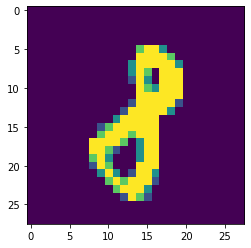

In [66]:
import struct
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image

from hw5_utils import BASE_URL, download, GANDataset


class DNet(nn.Module):
    """This is discriminator network."""

    def __init__(self):
        super(DNet, self).__init__()
        
        # TODO: implement layers here
        
        
        self.conv2_1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=1)
        self.relu_1 = nn.ReLU()
        self.maxpool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2_2 = nn.Conv2d(2, 4, 3, 1, 1)
        self.relu_2 = nn.ReLU()
        self.maxpool_2 = nn.MaxPool2d(2, 2)
        self.conv2_3 = nn.Conv2d(4, 8, 3, 1, 0)
        self.relu_3 =  nn.ReLU()
        self.fc = nn.Linear(200, 1)

        self._weight_init()


    def _weight_init(self):
        i = 1
        for module in self.children():
#             print(module.get_weight() = True)
#             if module != nn.ReLU():
            if i != 2 and i != 5 and i != 3 and i != 6 and i!=8:
                # print(module)
#             module.weight = nn.init.kaiming_uniform()
                nn.init.kaiming_uniform_(module.weight)
                module.bias.data.fill_(0.0)
            i+=1
 
    def forward(self, x):
        # TODO: complete forward function
#         x.view(x.size(0), 784)
        # print(x.shape)
        # print((self.maxpool_2(self.relu_2(self.conv2_2(self.maxpool_1(self.relu_1(self.conv2_1(x))))))).shape)
        temp = self.relu_3(self.conv2_3(self.maxpool_2(self.relu_2(self.conv2_2(self.maxpool_1(self.relu_1(self.conv2_1(x))))))))
        # print("temp: ", temp.shape)
        # print(temp.view(temp.size(0), -1).shape)
        return self.fc(temp.view(temp.size(0), -1))
#         return self.fc(nn.flatten(self.conv2_3(self.maxpool_2(self.relu_2(self.conv2_2(self.maxpool_1(self.relu_1(self.conv2_1(x)))))))))


class GNet(nn.Module):
    """This is generator network."""

    def __init__(self, zdim):
        """
        Parameters
        ----------
            zdim: dimension for latent variable.
        """
        super(GNet, self).__init__()

        # TODO: implement layers here
        self.linear = nn.Linear(zdim,1568)
        self.LeakyReLu = nn.LeakyReLU(0.2)
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv2d = nn.Conv2d(32,16, 3,1,1)
        self.LeakyReLu2 = nn.LeakyReLU(0.2)
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.conv2d2 = nn.Conv2d(16,8,3,1,1)
        self.LeakyReLu3 = nn.LeakyReLU(0.2)
        self.conv2d3 = nn.Conv2d(8, 1, 3, 1, 1)
        self.sigmoid = nn.Sigmoid()
        self._weight_init()

    def _weight_init(self):
        # TODO: implement weight initialization here
        i = 1
        for module in self.children():
#             print(module.weight)
#             if (module != ReLU()):
#             module.weight = nn.init.kaiming_uniform()
            if i != 2 and i!=3 and i != 5 and i!=6 and i != 8 and i != 10:  #use..  if isinstance(child, (nn.Linear, nn.Conv2d))
                nn.init.kaiming_uniform_(module.weight)
                module.bias.data.fill_(0.0)
            i+=1

    def forward(self, z):
        """
        Parameters
        ----------
            z: latent variables used to generate images.
        """
        # TODO: complete forward function
        temp = self.LeakyReLu(self.linear(z))
        return self.sigmoid(self.conv2d3(self.LeakyReLu3(self.conv2d2(self.upsample2(self.LeakyReLu2(self.conv2d(self.upsample(temp.view(-1,32,7,7)))))))))

class GAN:
    def __init__(self, zdim=64):
        """
        Parameters
        ----------
            zdim: dimension for latent variable.
        """
        torch.manual_seed(2)
        self._dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self._zdim = zdim
        self.disc = DNet().to(self._dev)
        self.gen = GNet(self._zdim).to(self._dev)

    def _get_loss_d(self, batch_size, batch_data, z):
        """This function computes loss for discriminator.

        Parameters
        ----------
            batch_size: #data per batch.
            batch_data: data from dataset.
            z: random latent variable.
        """
        # TODO: implement discriminator's loss function
        loss_d = 0
        # print(batch_data.shape)
        # print("size", batch_size)
        criterion = nn.BCEWithLogitsLoss()
        # for i in range (batch_size):
        # print(torch.zeros(batch_data.shape).shape)
        # print(self.disc(self.gen(z)).shape)
        zeros = torch.zeros(batch_size , 1).to(self._dev)
        loss_d += criterion( self.disc(self.gen(z)), zeros) #z.shape[0] is # of z's.  z shape: 5 * 64  #compare generated image vs zeros || compare real image vs ones
                                                                                    # only a zero for each data. not for each element of data.
        ones = torch.ones(batch_size , 1).to(self._dev)
        loss_d += criterion(self.disc(batch_data), ones)    #order of parameters matter?!
            # loss_d += criterion(batch_data[i,:,:,:],self.disc(self.gen(z.reshape(z.shape[0],1,8,8)))) #z.shape[0] is # of z's.  z shape: 5 * 64
        return loss_d/2

    def _get_loss_g(self, batch_size, z):
        """This function computes loss for generator.

        Parameters
        ----------
            batch_size: #data per batch.
            z: random latent variable.
        """
        # TODO: implement generator's loss function
        # print(batch_size)
        # print(z.shape)
        # print(self._zdim)
        loss_g = 0
        criterion = nn.BCEWithLogitsLoss()

        ones = torch.ones(batch_size , 1).to(self._dev)
        # for i in range (batch_size):
        loss_g += criterion(self.disc(self.gen(z)), ones)   #order of parameters matter?!
            # loss_g += criterion(batch_data[i,:],self.disc(z.reshape(z.shape[0],1,8,8)))     #z.shape[0] is # of z's.  z shape: 5 * 64    
        return loss_g

    def train(self, iter_d=1, iter_g=1, n_epochs=100, batch_size=256, lr=0.0002):

        # first download
        f_name = "train-images-idx3-ubyte.gz"
        download(BASE_URL + f_name, f_name)

        print("Processing dataset ...")
        train_data = GANDataset(
            f"./data/{f_name}",
            self._dev,
            transform=transforms.Compose([transforms.Normalize((0.0,), (255.0,))]),
        )
        print(f"... done. Total {len(train_data)} data entries.")

        train_loader = DataLoader(
            train_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            drop_last=True,
        )

        dopt = optim.Adam(self.disc.parameters(), lr=lr, weight_decay=0.0)
        dopt.zero_grad()
        gopt = optim.Adam(self.gen.parameters(), lr=lr, weight_decay=0.0)
        gopt.zero_grad()

        for epoch in tqdm(range(n_epochs)):
            for batch_idx, data in tqdm(
                enumerate(train_loader), total=len(train_loader)
            ):

                z = 2 * torch.rand(data.size()[0], self._zdim, device=self._dev) - 1

                if batch_idx == 0 and epoch == 0:
                    plt.imshow(data[0, 0, :, :].detach().cpu().numpy())
                    plt.savefig("goal.pdf")

                if batch_idx == 0 and epoch % 10 == 0:
                    with torch.no_grad():
                        tmpimg = self.gen(z)[0:64, :, :, :].detach().cpu()
                    save_image(
                        tmpimg, "test_{0}.png".format(epoch), nrow=8, normalize=True
                    )

                dopt.zero_grad()
                for k in range(iter_d):
                    loss_d = self._get_loss_d(batch_size, data, z)
                    loss_d.backward()
                    dopt.step()
                    dopt.zero_grad()

                gopt.zero_grad()
                for k in range(iter_g):
                    loss_g = self._get_loss_g(batch_size, z)
                    loss_g.backward()
                    gopt.step()
                    gopt.zero_grad()

            print(f"E: {epoch}; DLoss: {loss_d.item()}; GLoss: {loss_g.item()}")


if __name__ == "__main__":
    gan = GAN()
    gan.train()
